In [1]:
"""
A simplified Ichimoku Cloud strategy:
- Buys when price > Cloud and Conversion line > Base line
- Sells when price < Cloud and Conversion line < Base line
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def download_data(ticker="BTC-USD", start="2021-01-01", end="2023-01-01"):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace=True)
    df.dropna(inplace=True)
    return df


In [2]:
def ichimoku(df, conversion_period=9, base_period=26, span_b_period=52):
    """
    Ichimoku components:
    - Conversion line (tenkan-sen) = (9-period high + 9-period low)/2
    - Base line (kijun-sen)       = (26-period high + 26-period low)/2
    - Leading span A = (conversion line + base line)/2 (shifted forward)
    - Leading span B = (52-period high + 52-period low)/2 (shifted forward)
    """
    high_9 = df['high'].rolling(conversion_period).max()
    low_9 = df['low'].rolling(conversion_period).min()
    df['conversion_line'] = (high_9 + low_9) / 2

    high_26 = df['high'].rolling(base_period).max()
    low_26 = df['low'].rolling(base_period).min()
    df['base_line'] = (high_26 + low_26) / 2

    high_52 = df['high'].rolling(span_b_period).max()
    low_52 = df['low'].rolling(span_b_period).min()
    
    # Shift leading spans into the future by base_period
    df['leading_span_a'] = ((df['conversion_line'] + df['base_line']) / 2).shift(base_period)
    df['leading_span_b'] = ((high_52 + low_52) / 2).shift(base_period)

    return df

In [3]:
def ichimoku_signals(df, base_period=26):
    """
    Simple approach:
    - Buy if future close > future cloud and conversion_line > base_line
    - Sell if future close < future cloud and conversion_line < base_line
    """
    df['signal'] = 0

    # Align price and lines to the future cloud (leading spans are already shifted)
    df['future_close'] = df['close'].shift(-base_period)
    df['future_conversion'] = df['conversion_line'].shift(-base_period)
    df['future_base'] = df['base_line'].shift(-base_period)

    buy_cond = (
        (df['future_close'] > df['leading_span_a']) &
        (df['future_close'] > df['leading_span_b']) &
        (df['future_conversion'] > df['future_base'])
    )
    sell_cond = (
        (df['future_close'] < df['leading_span_a']) &
        (df['future_close'] < df['leading_span_b']) &
        (df['future_conversion'] < df['future_base'])
    )

    df.loc[buy_cond, 'signal'] = 1
    df.loc[sell_cond, 'signal'] = -1

    # Optional: clean up temp columns
    df.drop(columns=['future_close', 'future_conversion', 'future_base'], inplace=True)

    return df

In [4]:
def backtest_strategy(df, initial_capital=10000):
    df['returns'] = df['close'].pct_change().fillna(0)
    df['strategy_returns'] = df['signal'].shift(1).fillna(0) * df['returns']
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
    
    final_value = initial_capital * df['cumulative_strategy'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital

    drawdown = (
        (df['cumulative_strategy'].cummax() - df['cumulative_strategy'])
        / df['cumulative_strategy'].cummax()
    )
    max_drawdown = drawdown.max()
    sharpe_ratio = (df['strategy_returns'].mean() / (df['strategy_returns'].std() + 1e-9)) * np.sqrt(252)
    
    result = {
        "Initial Capital": initial_capital,
        "Final Portfolio Value": round(final_value, 2),
        "Total Return": f"{total_return*100:.2f}%",
        "Max Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }
    return df, result

In [5]:

def plot_results(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['close'], label='Price')
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell')
    
    # Cloud (fill between span_a and span_b)
    ax.fill_between(df.index, df['leading_span_a'], df['leading_span_b'], alpha=0.1, label='Cloud')
    ax.set_title("Ichimoku Cloud Strategy - Price & Signals")
    ax.legend()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['cumulative_market'], label='Market Returns')
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy Returns')
    plt.title("Ichimoku Cloud Strategy - Equity Curve")
    plt.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True
Performance Metrics:
Initial Capital: 10000
Final Portfolio Value: 35607.62
Total Return: 256.08%
Max Drawdown: 30.47%
Sharpe Ratio: 1.2


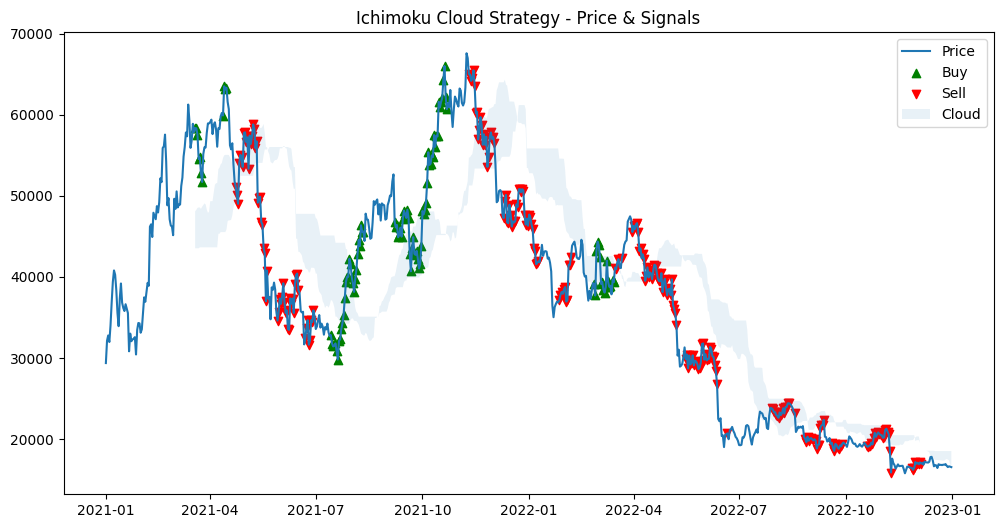

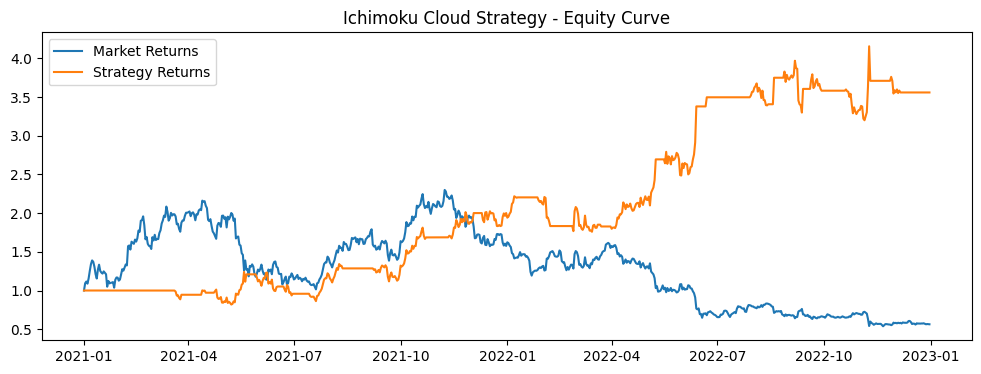

In [6]:
data = download_data("BTC-USD", "2021-01-01", "2023-01-01")
data = ichimoku(data)
data = ichimoku_signals(data)
data, metrics = backtest_strategy(data, initial_capital=10000)

print("Performance Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

plot_results(data)